# Chicago crime profile

Here we calculate supporting data and timeseries to summarize the crime profile in the city of Chicago. Much of the visualization will be written in D3, though there will be some visualization here for investigations or validation. 

We profile crime in the city by looking at the "Crime Gini". This coefficient measures how much of the crime affects certain people over others, i.e. the crime inequality. This will also be broken out by crime type.

This coefficient will be measured through time to elucidate trends in crime data, as well as put in context of how earnings distributions (a standard Gini coefficient) has changed through the years. We also will produce neighborhood stories, where parts of the city are crossed against the trends observed in the data, to see which areas have been doing well in terms of crime and income, and which have been doing poorly.

Once central dataframe of interest here is one whose columns are the important attributes, such as crime type, and whose index is dimensioned on neighborhood x year. The other central dataframe here is one keyed on month, whose features are Chicago-wide values, like gini coefficients, total crime, or total population.

Run time: 6 mins on i5 Gen 7 (single thread)
RAM reqs: 2GB

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

%matplotlib inline

## Helper functions to be migrated

In [2]:
def multi_timeseries_explore_plot(df_ts, ylabel = None, title = None, cols_per_plot = 16):
    for i in range(len(df_ts.columns)//cols_per_plot + 1):
        cols_offset = cols_per_plot * i
        cols_to_plot = range(cols_offset,  min(len(df_ts.columns), cols_offset + cols_per_plot))
        df_ts[df_ts.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
        if title:
            plt.title(title)
        if ylabel:
            plt.ylabel(ylabel)
            
def get_lorenz_curve(values, weights):
    """
    Return lorenz curve for values associated with weights population. 
    The first element of a tuple entry is the number of people associated with the point
    The second element is the value
    """
    lorenz_unnormalized = sorted(zip(weights, values), key = lambda x: x[1])
    total_weight = sum(map(lambda row: row[0], lorenz_unnormalized))
    total_weighted_value = sum(map(lambda row: row[0] * row[1], lorenz_unnormalized))
    return np.cumsum([ (x[0] / total_weight, x[0] * x[1] / total_weighted_value) for x in lorenz_unnormalized ], axis = 0)
 
def get_top_percentile_level(pct_ppl, values, weights):
    """
    Return crime level for a target percentile above which crime is at least as bad as the level returned. 
    The first element of a tuple entry is the number of people associated with the point
    The second element is the value
    """
    total_weight = sum(weights)
    sorted_pairs_outright_weights = np.array(sorted(zip(weights, values), key = lambda x: x[1]))
    # with cumulative weights
    sorted_pairs = np.array(sorted_pairs_outright_weights)
    sorted_pairs[:,0] = np.cumsum(sorted_pairs[:,0], axis = 0) / total_weight
    idx = np.searchsorted(sorted_pairs[:,0], 1 - pct_ppl)
    x0, x1 = sorted_pairs[idx-1, 0], sorted_pairs[idx, 0]
    y0, y1 = sorted_pairs[idx-1, 1], sorted_pairs[idx, 1]
    m = (y1 - y0)/(x1 - x0)
    return m * ((1-pct_ppl) - x0) + y0
    
def gini(values, weights):
    """
    Return gini coefficient for values associated with weights population. 
    """
    lorenz_curve = get_lorenz_curve(values, weights)
    # width is how far horizontally we have indexed, height is how far along the vertical axis
    width, height, area = 0, 0, 0
    for point in lorenz_curve:
        area += (point[0] - width)*height + (point[0] - width)*(point[1] - height) / 2
        height = point[1]
        width = point[0]
    fair_area = height * width / 2.
    return (fair_area - area) / fair_area

def pct_of_crime_in_top_pct_ppl(lorenz_curve, pct_ppl):
    """
    Return percent of crime in top X percent of population (i.e. of those in most intense circumstances)
    Calculated as 1 - lorenz curve(1 - top pct to consider)
    Linearly interpolate between 2 closest matches
    """
    idx = np.searchsorted(lorenz_curve[:,0], 1 - pct_ppl)
    x0, x1 = lorenz_curve[idx-1, 0], lorenz_curve[idx, 0]
    y0, y1 = lorenz_curve[idx-1, 1], lorenz_curve[idx, 1]
    m = (y1 - y0)/(x1 - x0)
    return 1 - (m * ((1-pct_ppl) - x0) + y0)

## City population

Here we read in the neighborhood populations through time, in addition to the Chicago totals, from a previous analysis / notebook. Note that in that analysis we used full-sampling census data (2000 and 2010) combined with select higher uncertainty but more coincident data from 2008 to present. By interpolating this data we obtained our monthly population timeseries.

While the aggregate population appears relatively constant since 2008, there is variation at the neighborhood level.

In [3]:
neighb_population = pd.read_csv('./data/rob_paral_combined_monthly.csv')[[
    'neighborhood', 
    'time',
    'Total_demographic', 
    'Not Hispanic or Latino: Asian alone',
    'Not Hispanic or Latino: Black or African American alone',
    'Hispanic or Latino',
    'Not Hispanic or Latino: White alone',
    'Not Hispanic or Latino: Other'
]].rename(columns = {
    'Total_demographic'                                       : 'population', 
    'Not Hispanic or Latino: Asian alone'                     : 'asian',
    'Not Hispanic or Latino: Black or African American alone' : 'black',
    'Hispanic or Latino'                                      : 'latino',
    'Not Hispanic or Latino: White alone'                     : 'white',
    'Not Hispanic or Latino: Other'                           : 'other'
})

neighb_pct_population = neighb_population.drop(['neighborhood', 'time', 'population'], axis = 1)\
    .div(neighb_population['population'], axis = 0)
neighb_pct_population[['neighborhood', 'time']] = neighb_population[['neighborhood', 'time']]
    
neighb_population['time'] = pd.to_datetime(neighb_population['time']).dt.to_period('M')
neighb_pct_population['time'] = pd.to_datetime(neighb_pct_population['time']).dt.to_period('M')

In [4]:
neighb_population.head()

,neighborhood,time,population,asian,black,latino,white,other
0,ROGERS PARK,2000-06,63484.0,4063.000000,18767.000000,17639.00000,20170.000000,2845.000000
1,ROGERS PARK,2000-07,63393.5,4061.583333,18712.354167,17593.03125,20192.020833,2834.510417
2,ROGERS PARK,2000-08,63303.0,4060.166667,18657.708333,17547.06250,20214.041667,2824.020833
3,ROGERS PARK,2000-09,63212.5,4058.750000,18603.062500,17501.09375,20236.062500,2813.531250
4,ROGERS PARK,2000-10,63122.0,4057.333333,18548.416667,17455.12500,20258.083333,2803.041667


In [5]:
city_population = neighb_population.groupby(['time']).sum().reset_index()

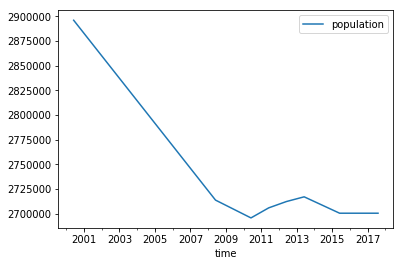

In [6]:
city_population.set_index('time')[['population']].plot()
plt.show()

In [7]:
neighb_population.head()

,neighborhood,time,population,asian,black,latino,white,other
0,ROGERS PARK,2000-06,63484.0,4063.000000,18767.000000,17639.00000,20170.000000,2845.000000
1,ROGERS PARK,2000-07,63393.5,4061.583333,18712.354167,17593.03125,20192.020833,2834.510417
2,ROGERS PARK,2000-08,63303.0,4060.166667,18657.708333,17547.06250,20214.041667,2824.020833
3,ROGERS PARK,2000-09,63212.5,4058.750000,18603.062500,17501.09375,20236.062500,2813.531250
4,ROGERS PARK,2000-10,63122.0,4057.333333,18548.416667,17455.12500,20258.083333,2803.041667


## City median income



In [8]:
rob_paral_income_raw = pd.read_csv('./data/rob_paral_combined_monthly.csv')

In [9]:
income_cols = [ col for col in rob_paral_income_raw.columns if '$' in col ]
income_cols

['Less than $10,000',
 '$10,000 to $14,999',
 '$15,000 to $19,999',
 '$20,000 to $24,999',
 '$25,000 to $29,999',
 '$30,000 to $34,999',
 '$35,000 to $39,999',
 '$40,000 to $44,999',
 '$45,000 to $49,999',
 '$50,000 to $59,999',
 '$60,000 to $74,999',
 '$75,000 to $99,999',
 '$100,000 to $124,999',
 '$125,000 to $149,999',
 '$150,000 to $199,999',
 '$200,000 or more']

In [10]:
def get_number_from_income_name(col):
    # just assign numbers for sake of median calc -- these will not affect median
    if 'Less' in col and '$10,000' in col:
        return 5000
    elif '$200,000' in col:
        return 250000 
    else: # this normalization will matter for median
        numbers = [ int(num) for num in col.replace(',', '').replace('$', '').split(' to ') ]
        return int(np.average(numbers) + 0.5)
        
income_col_number_map = { col : get_number_from_income_name(col) for col in income_cols }

In [11]:
def get_median_income_snap(row, num_map, num_cols):
    # first index of tupple is the percentile of population, second is the amount
    
    count_amts = sorted([ (row[col], num_map[col]) for col in num_cols ], key = lambda x: x[1])
    total_count = np.nansum([x[0] for x in count_amts])
    pct_amts = [ (x[0]/total_count, x[1]) for x in count_amts ]
    
    # find the two elements contributing to the med
    lower_cumulative_amt = pct_amts[0]
    upper_cumulative_amt = (pct_amts[0][0] + pct_amts[1][0], pct_amts[1][1]) # just for good practice...
    for x in pct_amts[1:]:
        upper_cumulative_amt = (x[0] + lower_cumulative_amt[0], x[1])
        if upper_cumulative_amt[0] > 0.5:
            break
        lower_cumulative_amt = upper_cumulative_amt
    
    # linear interpolation of median
    slope = (upper_cumulative_amt[1] - lower_cumulative_amt[1]) / (upper_cumulative_amt[0] - lower_cumulative_amt[0])
    
    return slope*(0.5 - lower_cumulative_amt[0]) + lower_cumulative_amt[1]

In [12]:
neighb_incomes = rob_paral_income_raw[['neighborhood', 'time'] + income_cols].copy()

In [13]:
neighb_incomes['median_income'] = \
    neighb_incomes.apply(get_median_income_snap, args = (income_col_number_map, income_cols), axis = 1)

In [14]:
neighb_incomes['time'] = pd.to_datetime(neighb_incomes['time']).dt.to_period('M')

### City of Chicago aggregates

In a separate dataframe lets calculate the city of chicago median income

In [15]:
chicago_incomes = neighb_incomes.drop(['neighborhood', 'median_income'], axis = 1).groupby('time').sum().reset_index()
chicago_incomes['median_income'] = \
    chicago_incomes.apply(get_median_income_snap, args = (income_col_number_map, income_cols), axis = 1)
chicago_incomes['neighborhood'] = 'CITY OF CHICAGO'

## Quick look at median incomes

First lets take a look at the Chicago median income, then the break-out by neighorhood

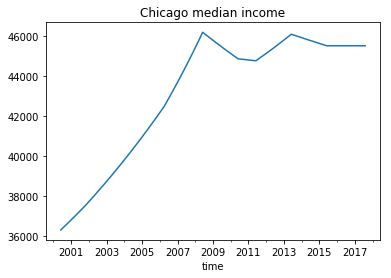

In [16]:
chicago_incomes.set_index('time')['median_income'].plot(title = 'Chicago median income')

plt.show()

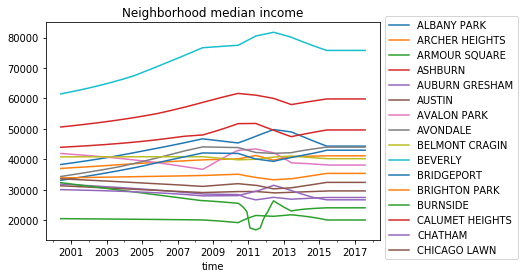

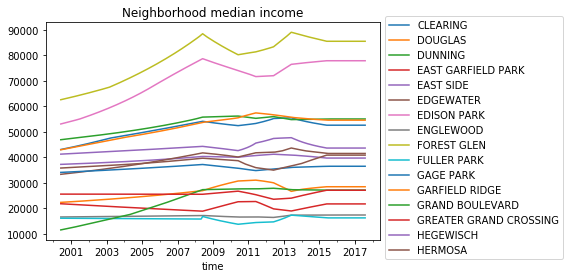

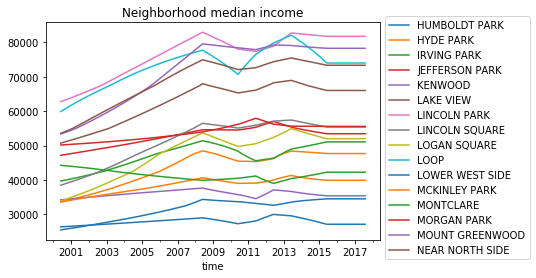

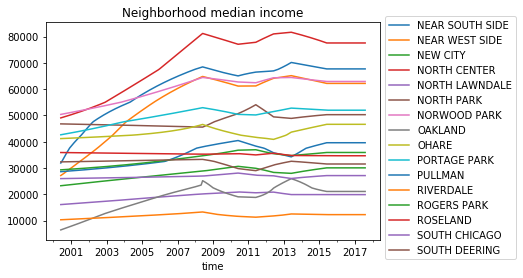

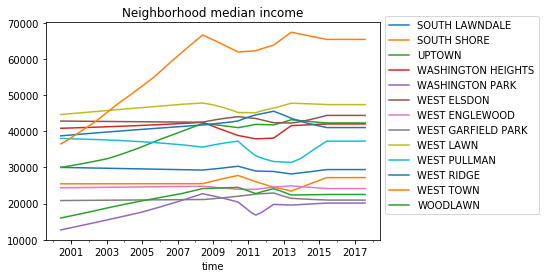

In [17]:
median_incomes_time = neighb_incomes\
    .reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = 'median_income')
    
multi_timeseries_explore_plot(median_incomes_time, title = 'Neighborhood median income')

plt.show()

## Crime summaries

Here we produce the timeseries of crimes and crimes per person for each crime type, and how they have changed through time. With this data in hand, we can calculate the crime Gini coefficient through time.

### Severity index

Lets calculate the "severity index" based off of the criminal sentencing of crimes as studied in http://convictions.smartchicagoapps.org/#intro

*NOTE* We do not have sentencing data on Liquor License violations, but since they are a very small fraction of crimes and are non-Index crimes, it will not materially affect our analysis. 

In [18]:
# Use the mean sentence as a proxy for severity of a crime
def min_sent_to_severity_index(mean_sent, median_sent, min_sent, max_sent):
    return mean_sent

In [19]:
crime_severity = pd.DataFrame(
    pd.read_csv('./data/parsed_convictions_minsent.csv').set_index('iucr')\
        .apply(lambda row: min_sent_to_severity_index(*row), axis = 1)
)
crime_severity.columns = ['severity_index']

In [20]:
crime_severity.head()

,severity_index
iucr,
0110,26.341289
0115,23.722222
0130,9.500000
0141,3.738734
0142,3.738734


In [21]:
crime_severity_dict = crime_severity.to_dict()['severity_index']
crime_severity_dict = { str(key).zfill(4) : crime_severity_dict[key] for key in crime_severity_dict }

# See below investigation why apply avg to 0460 and 0486
# Note that in the native data 0486 doesn't exist and instead 0486 is mapped to 0480 -- we don't want this
crime_severity_dict['0486'] = crime_severity_dict['0460']

In [22]:
crime_severity['severity_index'].min()

0.0

In [23]:
def get_severity(iucr, severity_dict):
    iucr_for_join = str(iucr).zfill(4)
    first_try = iucr_for_join
    second_try = iucr_for_join[:3] + '0'
    third_try = iucr_for_join[:2] + 'XX'
    if first_try in severity_dict:
        return severity_dict[first_try]
    elif second_try in severity_dict:
        return severity_dict[second_try]
    elif third_try in severity_dict:
        return severity_dict[third_try]
    else:
        return np.nan

In [24]:
individual_crimes = pd.read_csv('./data/cleaned_crimes.csv')

In [25]:
individual_crimes['time'] = pd.to_datetime(individual_crimes['date'], format = '%m/%d/%Y %I:%M:%S %p')\
    .dt.to_period('M')

In [26]:
individual_crimes['severity'] = individual_crimes['iucr'].map(lambda iucr: get_severity(iucr, crime_severity_dict))

### How does the severity compare to the incarceration rate?

Lets take a quick look at the total "time served" assuming an arrest leads to a conviction with the average "severity" (note severity here is mean yrs served). We'll use the endpoint population as a proxy for total population of the city (since this is a by-and-large / back of the envelope look). This is coming out to roughly 3-6% of the total population serving per year. This is very high compared to the ~1% of the population actually in prison.

Upon further investigation, it looks like the index crime rates largely coincide with other sources -- here we report non-index crimes as well. 

Due to other triangulation and accounting for other for factors below, the calculations here triangulate well. The severity index is the total years served per person (on average) assuming every person is arrested and serves full sentence for their crime (loosely). The apparent discrepancy above is loosely explained, and the actual crime rates as calculated triangulate with external sources (which tend to only report index crime rates; here we have both)

Differences in the total incarceration rate are likely due to (in product, on the order of 10% filter through to the state incarceration rate!)
1. Arrest rates (varies by crime, but ~0.3)
2. Fraction of prison sentence served (~0.75)
3. Fraction of people convicted for crime they were arrested for (~0.75)
5. Same individual committing many crimes (??)

In [27]:
# a look at arrest rates
individual_crimes['arrest'].sum()/len(individual_crimes)

0.28141212132828869

In [28]:
# a look at index vs non-index crimes in 2016
individual_crimes[individual_crimes['year']==2016].groupby('crime_is_index')[['severity']].agg(['mean', 'count'])

severity        
                    mean   count
crime_is_index                  
False           0.843239  146274
True            2.144743  115784

In [29]:
# index crime rates largely coincide with other sources
# https://en.wikipedia.org/wiki/Crime_in_Chicago
# --> note slight differences since we're using FBI classifications here
individual_crimes[individual_crimes['crime_is_index']]\
    .groupby(['year', 'crime_type', 'crime_description'])\
    .count()[['arrest']]\
    .reset_index()\
    .pivot_table(index = 'year', columns = ['crime_type', 'crime_description'], values = 'arrest') \
    / (city_population['population'].values[-1] / 100000)

crime_type          Property                                               \
crime_description      Arson    Burglary      Larceny Motor Vehicle Theft   
year                                                                        
2001               37.180090  963.016179  3671.756093         1018.786314   
2002               37.735570  948.018235  3627.910249          925.650929   
2003               35.180364  930.946500  3657.128468          841.810567   
2004               28.588675  909.579058  3532.997330          844.217644   
2005               25.366894  944.352070  3169.639716          832.848832   
2006               26.329725  900.728419  3191.673734          807.926321   
2007               25.959406  920.503487  3152.456886          687.794636   
2008               23.330136  970.385540  3268.848343          698.459841   
2009               22.478401  990.938279  2994.885886          572.921489   
2010               18.960365  978.458508  2842.166074          704.644178   
2011               18.441917  985.753804  2782.692742          717.901621   
2012               17.256894  845.958146  2794.283746          610.731122   
2013               13.257442  662.649933  2648.674071          465.899118   
2014               14.627625  539.555691  2279.132119          367.097842   
2015               16.590319  488.155327  2122.449886          372.985924   
2016               19.071461  529.112677  2278.576639          418.646334   
2017               11.183653  314.327296  1523.457897          273.851361   

crime_type                               Violent                     \
crime_description     Robbery Aggravated Assault Aggravated Battery   
year                                                                  
2001               682.165777         291.404511         606.694638   
2002               683.572992         285.368301         561.737836   
2003               641.541715         272.962594         461.899666   
2004               591.622629         271.333188         426.904461   
2005               594.140803         250.039809         419.572133   
2006               591.289342         244.299855         407.610809   
2007               572.106785         234.597481         413.054507   
2008               618.211578         231.449764         399.982225   
2009               591.548566         222.117710         375.578162   
2010               528.557198         195.417665         349.285468   
2011               517.743865         190.973830         311.179579   
2012               499.376011         180.456752         296.588986   
2013               437.717794         158.052415         245.595974   
2014               362.913230         160.570588         243.559216   
2015               356.951084         165.866159         260.001407   
2016               442.828205         211.489537         299.477479   
2017               274.221681         142.054607         195.010313   

crime_type                                                           
crime_description Criminal Sexual Assault Homicide 1st & 2nd Degree  
year                                                                 
2001                            79.581687                 24.700319  
2002                            80.840774                 24.292967  
2003                            72.693742                 22.256209  
2004                            70.619952                 16.775479  
2005                            69.064610                 16.701415  
2006                            65.028126                 17.442054  
2007                            67.694427                 16.590319  
2008                            63.732007                 18.997397  
2009                            59.399268                 17.034703  
2010                            56.695934                 16.219999  
2011                            60.176939                 16.145936  
2012                            57.473605                 

In [30]:
# severity over time -- 
individual_crimes[individual_crimes['arrest']].groupby('year')[['severity']].agg(['sum', 'count', 'mean']) /\
    city_population['population'].values[-1]

severity                        
           sum     count          mean
year                                  
2001  0.057312  0.050393  4.211671e-07
2002  0.058636  0.050208  4.324838e-07
2003  0.058568  0.050359  4.306870e-07
2004  0.059388  0.051806  4.245164e-07
2005  0.057195  0.050598  4.186088e-07
2006  0.055533  0.048764  4.217194e-07
2007  0.052136  0.047380  4.074931e-07
2008  0.045807  0.039561  4.287820e-07
2009  0.044399  0.039654  4.146360e-07
2010  0.039472  0.036115  4.047460e-07
2011  0.037809  0.034629  4.043345e-07
2012  0.036567  0.032702  4.140869e-07
2013  0.034260  0.030952  4.099064e-07
2014  0.031655  0.028020  4.183547e-07
2015  0.028608  0.024272  4.364715e-07
2016  0.024739  0.018342  4.994614e-07
2017  0.015372  0.011578  4.916541e-07

#### FYI: What is that Jump in 2003 and why treat 0460 and 0486 the same?

Upon a closer look, it appears there's a big spike in Simple Battery in 2003. This is likely due to reporting crimes differently. Drilling deeper, the rise in IUCR 0486 (Simple domestic battery) is the driver here. It appears that in 2002, there became a distinction between _battery_ (IUCR 0460) and _domestic battery_ (0486), the former having a lower median sentence than the latter.

Note that due to the 1 year rolling sums to avoid seasonality, this is likely due to a change in reporting in 2002, which is only fully incorporated by EOY 2002.

In [31]:
battery_iucr = individual_crimes[individual_crimes['crime_description'] == 'Simple Battery']\
    .groupby(['year', 'iucr'])[['date']]\
    .count()\
    .rename(columns = {'date' : 'crime_count'})

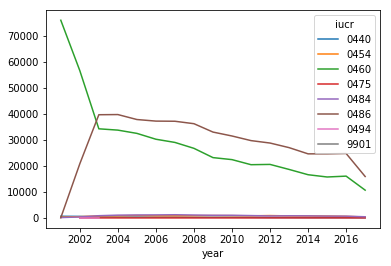

In [32]:
battery_iucr.reset_index().pivot(index = 'year', columns = 'iucr', values = 'crime_count').plot()

plt.show()

#### Filling in crimes that didn't get tagged with severity

It looks like almost entirely the crimes not tagged were miscellanous small offenses. Essentially irrelevant crimes, when considering things like battery, larceny, murder, etc.

There are a couple categories that don't seem to be getting tagged that are important -- but note that this is less than 1 in 2000 of overall crimes and should not impact our results significantly.

To handle these, we will apply the mean sentencing from their FBI code crime category.

In [33]:
individual_crimes[individual_crimes['severity'].isnull()].groupby('crime_description')\
    .agg(['count', 'sum'])['arrest']\
    .rename(columns = {'count' : 'crime_count', 'sum' : 'arrests_count'})

,crime_count,arrests_count
crime_description,,
Criminal Sexual Abuse,819,134.0
Disorderly Conduct,26,14.0
Liquor License,13746,13622.0
Misc Non-Index Offense,111047,47670.0
Simple Battery,1,1.0
Weapons Violation,2361,1764.0


In [34]:
mean_crime_severity_by_descr = individual_crimes\
    .groupby('crime_description')\
    .mean()[['severity']]\
    .rename(columns = {'severity' : 'mean_severity'})\
    .reset_index()

In [35]:
mean_crime_severity_by_descr

,crime_description,mean_severity
0,Aggravated Assault,2.303894
1,Aggravated Battery,2.561333
2,Arson,3.504391
3,Burglary,2.544236
4,Criminal Sexual Abuse,1.565359
5,Criminal Sexual Assault,9.478272
6,Disorderly Conduct,0.413220
7,Drug Abuse,0.753394
8,Embezzlement,0.608030
9,Forgery & Counterfeiting,0.821783


In [36]:
mean_severity = pd.merge(individual_crimes[['crime_description']], 
                         mean_crime_severity_by_descr,
                         on = 'crime_description',
                         how = 'left')

In [37]:
mean_severity.head()

,crime_description,mean_severity
0,Robbery,5.467185
1,Gambling,0.620222
2,Misc Non-Index Offense,0.646936
3,Simple Battery,0.526788
4,Drug Abuse,0.753394


In [38]:
len(mean_severity) - len(individual_crimes)

0

In [39]:
individual_crimes['severity'] = np.where(individual_crimes['severity'].isnull(),
                                         mean_severity['mean_severity'],
                                         individual_crimes['severity'])

### Neighborhood crime intensity

Now, using the severity index and the frequency of different crimes in different neighborhoods, lets get an idea of the intensity of crimes by types by neighborhood.

In [40]:
neighb_crimes_intermediate =\
    individual_crimes.groupby(['neighborhood', 'crime_description', 'crime_type', 'time'])[['severity']]\
    .sum().rename(columns = {'sum' : 'severity'})

In [41]:
neighb_crime_intensity = neighb_crimes_intermediate\
    .pivot_table(index = ['neighborhood', 'time'], 
                 columns = ['crime_type', 'crime_description'],
                 values = 'severity')\
    .fillna(0)\
    .groupby(level = 'neighborhood', group_keys = False)\
    .rolling(12).sum()

In [42]:
neighb_crimes_population_ref = pd.DataFrame(index = neighb_crime_intensity.index)\
    .join(neighb_population.set_index(['neighborhood', 'time']))['population']

neighb_crimes_percapita = neighb_crime_intensity.copy().div(neighb_crimes_population_ref, axis = 0)

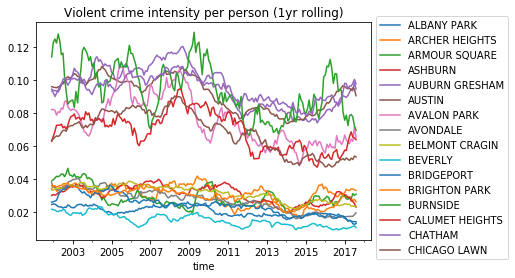

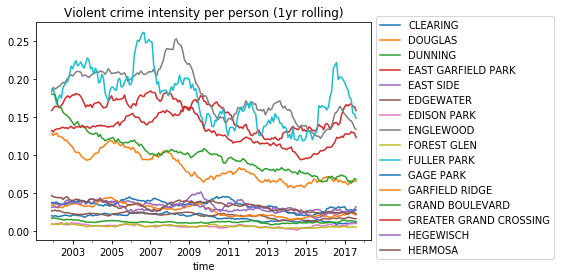

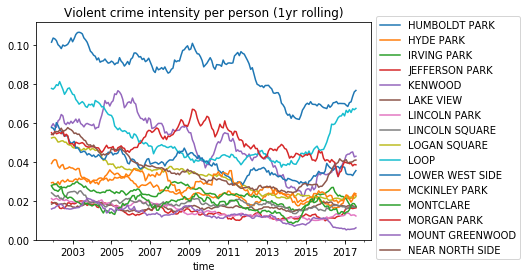

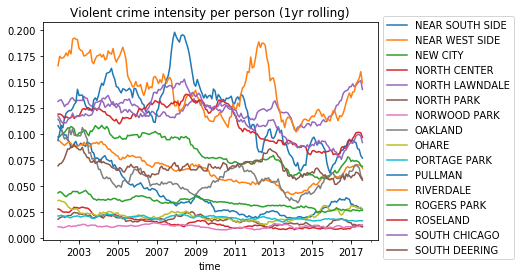

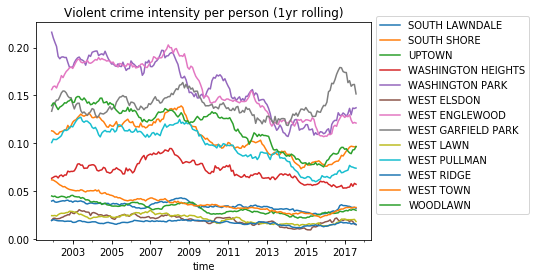

In [43]:
category = 'Violent'

crime_category_time = neighb_crimes_percapita.sum(axis = 1, level = 0)[[category]]\
    .reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = category)

multi_timeseries_explore_plot(crime_category_time, title = category + ' crime intensity per person (1yr rolling)')

plt.show()

### City of Chicago Crime Intensity and Crime Occurrence

A similar analysis to the above allows us to produce the mean crime severity throughout the entire city through time

In [44]:
chicago_crimes_intermediate =\
    individual_crimes.groupby(['crime_description', 'crime_type', 'time'])['severity']\
    .agg(['sum', 'count']).rename(columns = {'sum' : 'severity', 'count' : 'occurrence'})

In [45]:
chicago_crime_intensity = chicago_crimes_intermediate\
    .pivot_table(index = 'time', 
                 columns = ['crime_type', 'crime_description'],
                 values = 'severity')\
    .fillna(0)\
    .rolling(12).sum()

In [46]:
chicago_crime_intensity_ref = pd.DataFrame(index = chicago_crime_intensity.index)\
    .join(city_population.set_index(['time'])[['population']])['population']

chicago_crimes_percapita = chicago_crime_intensity.copy().div(chicago_crime_intensity_ref, axis = 0)

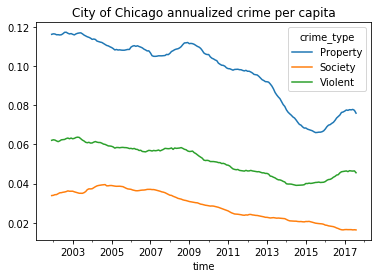

In [47]:
chicago_crimes_percapita.sum(level=0, axis=1).plot(title = 'City of Chicago annualized crime per capita')

plt.show()

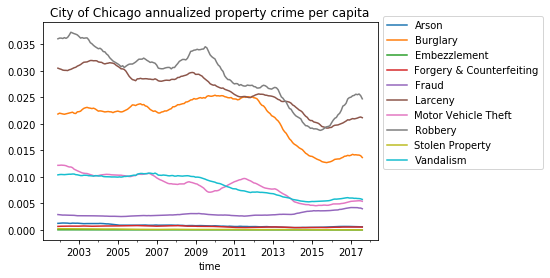

In [48]:
chicago_crimes_percapita['Property']\
    .plot(title = 'City of Chicago annualized property crime per capita')\
    .legend(bbox_to_anchor=(1, 1.05))
plt.show()

#### Crime counts

Naive approaches to try to understand will often just look at crime occurrence. Here we compare occurrence to intensity to illustrate the impact attempting to size crime up appropriately has on the prevelance and impact of crimes in Chicago. The timeframe here will be the most recent 5 years.

In [49]:
chicago_crime_occurrence = chicago_crimes_intermediate\
    .pivot_table(index = 'time', 
                 columns = ['crime_type', 'crime_description'],
                 values = 'occurrence')\
    .fillna(0)\
    .rolling(12).sum()

In [50]:
chicago_crime_occurrence_ref = pd.DataFrame(index = chicago_crime_occurrence.index)\
    .join(city_population.set_index(['time'])[['population']])['population']

chicago_crime_occurrence_percapita = chicago_crime_occurrence.copy().div(chicago_crime_occurrence_ref, axis = 0)

In [51]:
chicago_crime_occurrence.tail()

crime_type        Property                                                 \
crime_description    Arson Burglary Embezzlement Forgery & Counterfeiting   
time                                                                        
2017-04              506.0  14439.0         37.0                   1883.0   
2017-05              489.0  14385.0         33.0                   1863.0   
2017-06              493.0  14375.0         33.0                   1857.0   
2017-07              479.0  14217.0         28.0                   1809.0   
2017-08              469.0  13850.0         24.0                   1773.0   

crime_type                                                        \
crime_description    Fraud  Larceny Motor Vehicle Theft  Robbery   
time                                                               
2017-04            16191.0  62364.0             11641.0  12153.0   
2017-05            16219.0  62632.0             11651.0  12099.0   
2017-06            15991.0  63001.0             11734.0  12174.0   
2017-07            15991.0  63182.0             11702.0  12051.0   
2017-08            15496.0  62738.0             11514.0  11834.0   

crime_type                                       ...        \
crime_description Stolen Property Vandalism      ...         
time                                             ...         
2017-04                      41.0   30756.0      ...         
2017-05                      39.0   30537.0      ...         
2017-06                      41.0   30468.0      ...         
2017-07                      37.0   30214.0      ...         
2017-08                      44.0   29625.0      ...         

crime_type                        Society                                  \
crime_description Offenses Against Family Prostitution  Weapons Violation   
time                                                                        
2017-04                            1957.0         788.0            3888.0   
2017-05                            1932.0         792.0            3943.0   
2017-06                            1886.0         807.0            4032.0   
2017-07                            1875.0         789.0            4248.0   
2017-08                            1859.0         782.0            4316.0   

crime_type                   Violent                     \
crime_description Aggravated Assault Aggravated Battery   
time                                                      
2017-04                       5813.0             8044.0   
2017-05                       5824.0             8043.0   
2017-06                       5845.0             8042.0   
2017-07                       5865.0             8052.0   
2017-08                       5750.0             7857.0   

crime_type                                                           \
crime_description Criminal Sexual Assault Homicide 1st & 2nd Degree   
time                                                                  
2017-04                            1653.0                     785.0   
2017-05                            1638.0                     775.0   
2017-06                            1607.0                     783.0   
2017-07                            1604.0                     789.0   
2017-08                            1583.0                     746.0   

crime_type                                                                
crime_description Involuntary Manslaughter Simple Assault Simple Battery  
time                                                                      
2017-04                                4.0        13285.0        41629.0  
2017-05                                4.0        13337.0        41472.0  
2017-06                                3.0        13346.0        41264.0  
2017-07                                2.0        13432.0        41258.0  
2017-08                                2.0        13274.0        40786.0  

[5 rows x 26 columns]

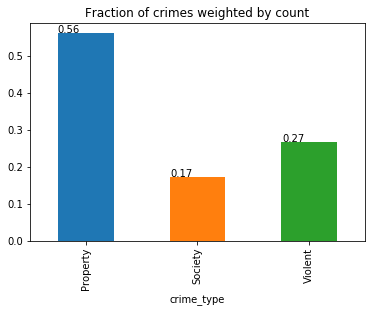

In [52]:
ax = (chicago_crime_occurrence.sum(axis = 1, level = 0).iloc[-1] / \
 chicago_crime_occurrence.sum(axis = 1).iloc[-1]
).plot(kind='bar', title = 'Fraction of crimes weighted by count')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

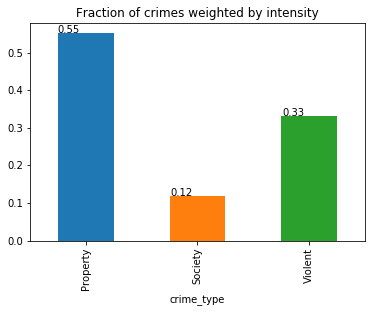

In [53]:
ax = (chicago_crimes_percapita.sum(axis = 1, level = 0).iloc[-1] / \
 chicago_crimes_percapita.sum(axis = 1).iloc[-1]
).plot(kind='bar', title = 'Fraction of crimes weighted by intensity')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

### Average crime intensity over time

Now we can look at the average crime intensity over time -- i.e. how severe is the average crime?

In [54]:
average_single_crime_intensity = pd.concat([
    chicago_crime_intensity.sum(axis = 1, level = 0) / chicago_crime_occurrence.sum(axis = 1, level = 0),
    pd.DataFrame({
        'Total' : chicago_crime_intensity.sum(axis = 1) / chicago_crime_occurrence.sum(axis = 1)
    }),
], axis = 1)

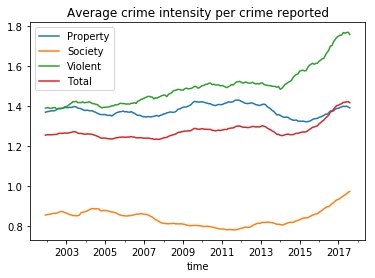

In [55]:
average_single_crime_intensity.plot(title = 'Average crime intensity per crime reported')
plt.show()

### Race crime share

We can also look at density of race in each neighborhood to get a proxy of how crime affects various races

We do this by taking the neighborhood per capita crime, which is the approximately same at the race level within the neighborhood, and doing a race-weighted-average across the city.

What this means is we weight crime by the race populations in the neighborhood compared to the total race population in the city.

In [56]:
neighb_population_pct_total = pd.merge(
    pd.melt(neighb_population.drop('population', axis = 1), 
            id_vars = ['neighborhood', 'time'], 
            var_name = 'race',
            value_name = 'neighb_pop').reset_index(),
    pd.melt(city_population.drop('population', axis = 1), 
            id_vars = ['time'], 
            var_name = 'race',
            value_name = 'city_pop').reset_index(),
    on = ['time', 'race']
)
neighb_population_pct_total['city_race_pct'] = neighb_population_pct_total['neighb_pop'] / neighb_population_pct_total['city_pop']
neighb_population_pct_total = neighb_population_pct_total[['neighborhood', 'time', 'race', 'city_race_pct']]
neighb_population_pct_total = neighb_population_pct_total.sort_values(['neighborhood', 'time']).reset_index(drop = True)

In [57]:
crimes_per_capita_melted = \
    pd.melt(neighb_crimes_percapita.reset_index(), id_vars = ['neighborhood', 'time'], value_name = 'severity')

crimes_per_capita_race_intermediate = pd.merge(crimes_per_capita_melted, 
                                               neighb_population_pct_total, 
                                               on = ['neighborhood', 'time'])
crimes_per_capita_race_intermediate['weighted_severity'] = \
    crimes_per_capita_race_intermediate['severity'] * crimes_per_capita_race_intermediate['city_race_pct']
    
crimes_per_capita_race = crimes_per_capita_race_intermediate\
    .pivot_table(index = ['race', 'time'], 
                 columns = ['crime_type', 'crime_description'], 
                 values = ['weighted_severity'], aggfunc = np.sum)['weighted_severity']

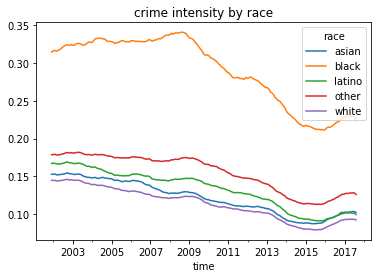

In [58]:
race_over_time = crimes_per_capita_race.sum(axis = 1)\
    .reset_index()\
    .pivot(index = 'time', columns = 'race')[0]

race_over_time.plot(title = 'crime intensity by race')

plt.show()

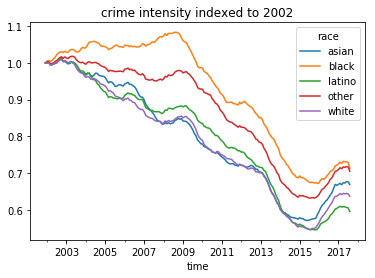

In [59]:
race_over_time_indexed = race_over_time.div(race_over_time.loc[race_over_time.first_valid_index()], axis = 1)

race_over_time_indexed.plot(title = 'crime intensity indexed to 2002')

plt.show()

### City crime Gini coefficients

In [60]:
crime_types_for_gini = np.append(neighb_crimes_percapita.columns.levels[0].values, 'Total')

crimes_for_gini_prep = neighb_crimes_percapita.sum(axis = 1, level = 0)
crimes_for_gini_prep['Total'] = crimes_for_gini_prep.sum(axis = 1)
crimes_for_gini_prep['pop_weight'] = neighb_crimes_population_ref
crimes_for_gini_prep = crimes_for_gini_prep.reset_index().pivot(index = 'time', columns = 'neighborhood')

In [61]:
crime_gini_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)

for ct in crime_types_for_gini:
    crime_gini_timeseries[ct] = \
        crimes_for_gini_prep.apply(lambda row: gini(row[ct].values, row['pop_weight'].values), axis = 1)

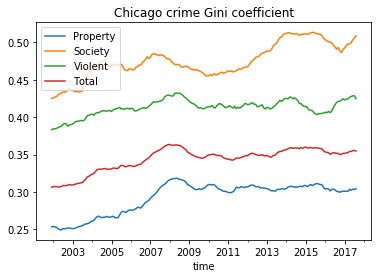

In [62]:
crime_gini_timeseries.plot(title = 'Chicago crime Gini coefficient')
plt.show()

### Crime concentrations in top/bot of city

On the way we can also calculate crime levels for top / bot populations.

Note -- we need to get the crime PER CAPITA from a subset of the population containing a calculated $x$ percent of total crime. This means that the aggregate crime in that subset is $xCP$, where $C$ is the city crime per capita and $P$ is the total population. Hence the crime per person is $xC/s$ where $s$ is the percentile (i.e. here 20%). Thus, the crime per captia is (percent of crime contained) * (city crime per capita) / (percent of city represented)

Hence this level calculation will produce the average crime level felt by the top/bottom percentiles.

In [63]:
chicago_crime_level_for_top_bot = chicago_crimes_percapita.sum(level = 0, axis = 1)
chicago_crime_level_for_top_bot['Total'] = chicago_crimes_percapita.sum(axis = 1)
crime_top_pct_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)
crime_top_pctile_level_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)
crime_top_avg_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index) 
crime_bot_pct_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)
crime_bot_avg_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)
crime_bot_pctile_level_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)

top_pct_consider = 0.25
for ct in crime_types_for_gini:
    
    crime_top_pct_timeseries[ct] = \
        crimes_for_gini_prep.apply(lambda row: pct_of_crime_in_top_pct_ppl(
                                       get_lorenz_curve(row[ct].values, row['pop_weight'].values), 
                                       top_pct_consider),
                                   axis = 1)
        
    crime_top_pctile_level_timeseries[ct] = crimes_for_gini_prep.apply(lambda row: get_top_percentile_level(
                                       top_pct_consider,
                                       row[ct].values, 
                                       row['pop_weight'].values), 
                                   axis = 1)
    
    crime_top_avg_timeseries[ct] = crime_top_pct_timeseries.join(chicago_crime_level_for_top_bot, rsuffix='chicago')\
        .apply(lambda row: row[ct] * row[ct+'chicago'], axis = 1) / top_pct_consider
    
    crime_bot_pct_timeseries[ct] = \
        crimes_for_gini_prep.apply(lambda row: 1 - pct_of_crime_in_top_pct_ppl(
                                       get_lorenz_curve(row[ct].values, row['pop_weight'].values), 
                                       1 - top_pct_consider),
                                   axis = 1)
    
    crime_bot_avg_timeseries[ct] = crime_bot_pct_timeseries.join(chicago_crime_level_for_top_bot, rsuffix='chicago')\
        .apply(lambda row: row[ct] * row[ct+'chicago'], axis = 1) / top_pct_consider
        
    crime_bot_pctile_level_timeseries[ct] = crimes_for_gini_prep.apply(lambda row: get_top_percentile_level(
                                       1 - top_pct_consider,
                                       row[ct].values, 
                                       row['pop_weight'].values), 
                                   axis = 1)

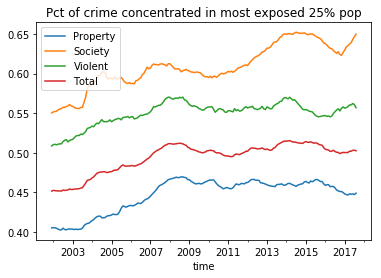

In [64]:
crime_top_pct_timeseries.plot(title = 'Pct of crime concentrated in most exposed ' + str(round(100 * top_pct_consider)) + '% pop')
plt.show()

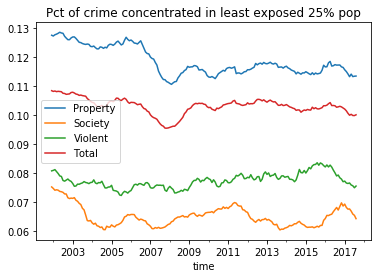

In [65]:
crime_bot_pct_timeseries.plot(title = 'Pct of crime concentrated in least exposed ' + str(round(100 * top_pct_consider)) + '% pop')
plt.show()

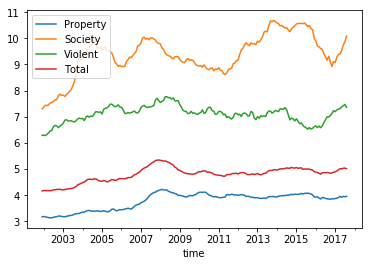

In [66]:
(crime_top_pct_timeseries / crime_bot_pct_timeseries.values).plot()

plt.show()

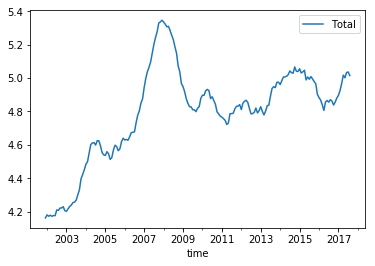

In [67]:
crime_top_bot_ratio_timeseries = (crime_top_pct_timeseries / crime_bot_pct_timeseries.values)

crime_top_bot_ratio_timeseries[['Total']].plot()

plt.show()

### Make a single dataframe with top/bot ratio, level, and chicago avg

In [68]:
crime_top_bot = pd.concat([
    pd.melt(chicago_crime_level_for_top_bot.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'chicago_crime')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_top_pct_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_top_pct')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_bot_pct_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_bot_pct')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_top_avg_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_top_avg')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_bot_avg_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_bot_avg')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_top_pctile_level_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_top_pctile_lvl')\
        .set_index(['crime_type', 'time']),
    pd.melt(crime_bot_pctile_level_timeseries.reset_index(), 
        id_vars = 'time', var_name = 'crime_type', value_name = 'crime_bot_pctile_lvl')\
        .set_index(['crime_type', 'time'])    
], axis = 1).reset_index()\
    .pivot_table(index = 'time', columns = 'crime_type')\
    .swaplevel(1, 0, axis = 1)\
    .sort_index(axis = 1)

In [69]:
crime_top_bot.tail()

crime_type      Property                                                   \
           chicago_crime crime_bot_avg crime_bot_pct crime_bot_pctile_lvl   
time                                                                        
2017-04         0.077705      0.035231      0.113350             0.042987   
2017-05         0.077601      0.035457      0.114228             0.043900   
2017-06         0.077819      0.035295      0.113387             0.043909   
2017-07         0.077355      0.035124      0.113515             0.043101   
2017-08         0.075920      0.034488      0.113567             0.041996   

crime_type                                                        Society  \
           crime_top_avg crime_top_pct crime_top_pctile_lvl chicago_crime   
time                                                                        
2017-04         0.139331      0.448270             0.107754      0.016501   
2017-05         0.138974      0.447719             0.105144      0.016495   
2017-06         0.139521      0.448221             0.106559      0.016355   
2017-07         0.138409      0.447318             0.108257      0.016433   
2017-08         0.136387      0.449115             0.105954      0.016345   

crime_type                                     ...                  Total  \
           crime_bot_avg crime_bot_pct         ...          crime_top_avg   
time                                           ...                          
2017-04         0.004472      0.067750         ...               0.282669   
2017-05         0.004421      0.067000         ...               0.282165   
2017-06         0.004317      0.065988         ...               0.282809   
2017-07         0.004309      0.065548         ...               0.282380   
2017-08         0.004210      0.064398         ...               0.276953   

crime_type                                          Violent                \
           crime_top_pct crime_top_pctile_lvl chicago_crime crime_bot_avg   
time                                                                        
2017-04         0.501994             0.205660      0.046567      0.014287   
2017-05         0.502007             0.203529      0.046422      0.014113   
2017-06         0.503107             0.204256      0.046357      0.014044   
2017-07         0.503304             0.205437      0.046475      0.013952   
2017-08         0.502514             0.200223      0.045519      0.013772   

crime_type                                                                 \
           crime_bot_pct crime_bot_pctile_lvl crime_top_avg crime_top_pct   
time                                                                        
2017-04         0.076702             0.017406      0.104375      0.560352   
2017-05         0.076004             0.017430      0.104070      0.560458   
2017-06         0.075738             0.017068      0.104242      0.562173   
2017-07         0.075054             0.016838      0.104240      0.560732   
2017-08         0.075637             0.016702      0.101388      0.556843   

crime_type                       
           crime_top_pctile_lvl  
time                             
2017-04                0.069036  
2017-05                0.070122  
2017-06                0.069167  
2017-07                0.069779  
2017-08                0.067446  

[5 rows x 28 columns]

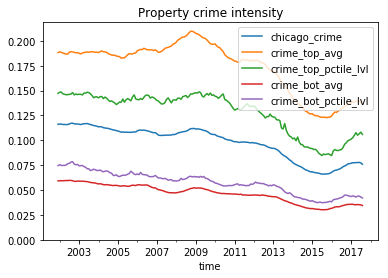

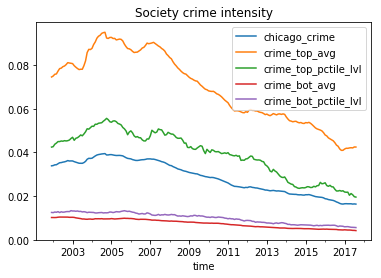

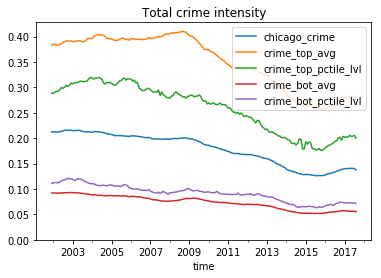

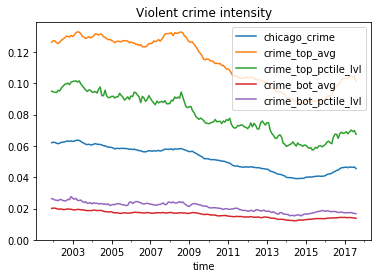

In [70]:
for ct in crime_top_bot.columns.levels[0]:
    crime_top_bot[ct][['chicago_crime', 'crime_top_avg', 'crime_top_pctile_lvl', 'crime_bot_avg', 'crime_bot_pctile_lvl']].plot(title = ct + ' crime intensity')
    plt.gca().set_ylim(bottom=0)
plt.show()

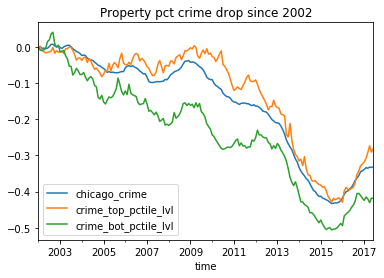

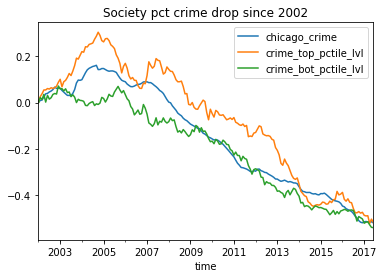

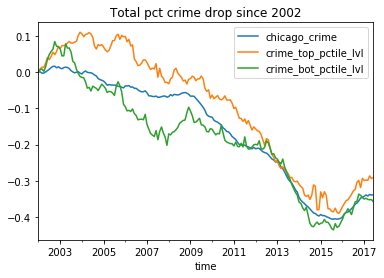

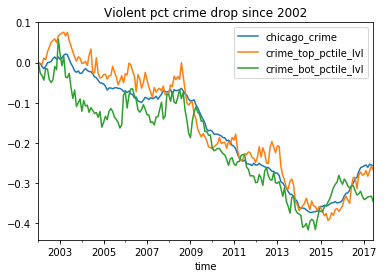

In [71]:
for ct in crime_top_bot.columns.levels[0]:
    (-1 + crime_top_bot[ct].div(crime_top_bot[ct].loc['2002-01'], axis = 1)\
        [['chicago_crime', 'crime_top_pctile_lvl', 'crime_bot_pctile_lvl']]).plot(title = ct + ' pct crime drop since 2002')
    plt.xlim('2002-01', '2017-06')
plt.show()

In [72]:
for col in crime_top_bot.columns.levels[0]:
    print(col)
    print((1 - crime_top_bot[col].div(crime_top_bot[col].loc['2002-01'], axis = 1)\
        [['chicago_crime', 'crime_top_avg', 'crime_bot_avg']]).tail(1))
    print()

Property
         chicago_crime  crime_top_avg  crime_bot_avg
time                                                
2017-08       0.347716       0.277679       0.418432

Society
         chicago_crime  crime_top_avg  crime_bot_avg
time                                                
2017-08       0.519095       0.433558       0.586044

Total
         chicago_crime  crime_top_avg  crime_bot_avg
time                                                
2017-08       0.352245       0.280818       0.400509

Violent
         chicago_crime  crime_top_avg  crime_bot_avg
time                                                
2017-08       0.269722       0.203026       0.318389



### And some more gini break-outs...

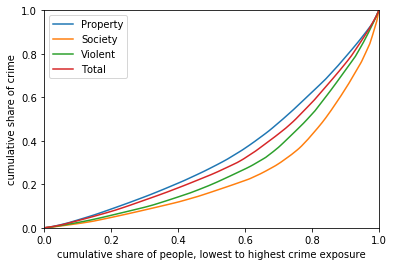

In [73]:
for ct in crime_types_for_gini:
    last_idx = crimes_for_gini_prep.index[-1]
    x, y = zip(*get_lorenz_curve(crimes_for_gini_prep.loc[last_idx][ct], crimes_for_gini_prep.loc[last_idx]['pop_weight']))
    plt.plot(x, y, label = ct)
plt.xlabel('cumulative share of people, lowest to highest crime exposure')
plt.ylabel('cumulative share of crime')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

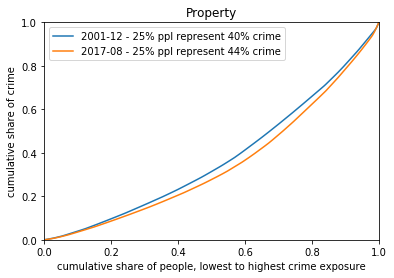

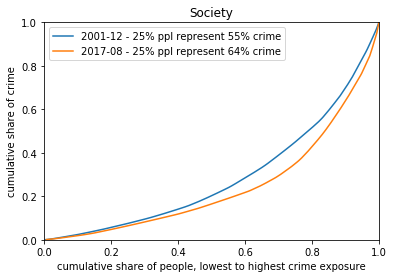

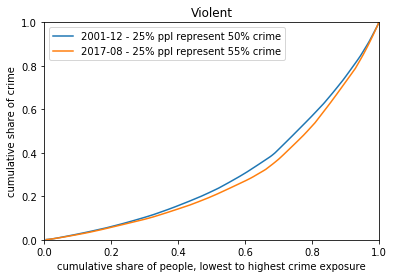

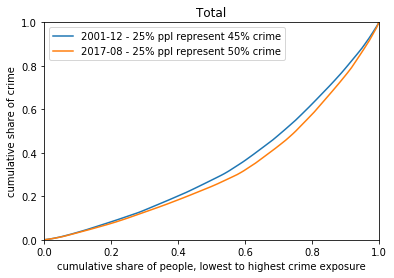

In [74]:
top_pct_consider = 0.25
first_idx = crimes_for_gini_prep.index[~crimes_for_gini_prep['Total'].sum(axis = 1).isnull()][0]
last_idx = crimes_for_gini_prep.index[-1]
for ct in crime_types_for_gini:
    plt.xlabel('cumulative share of people, lowest to highest crime exposure')
    plt.ylabel('cumulative share of crime')
    plt.title(ct)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    tmp_lorenz_curve = get_lorenz_curve(crimes_for_gini_prep.loc[first_idx][ct], crimes_for_gini_prep.loc[first_idx]['pop_weight'])
    top_crime_initial = pct_of_crime_in_top_pct_ppl(tmp_lorenz_curve, top_pct_consider)
    x, y = zip(*tmp_lorenz_curve)
    plt.plot(x, y, label = ct)
    tmp_lorenz_curve = get_lorenz_curve(crimes_for_gini_prep.loc[last_idx][ct], crimes_for_gini_prep.loc[last_idx]['pop_weight'])
    top_crime_final = pct_of_crime_in_top_pct_ppl(tmp_lorenz_curve, top_pct_consider)
    x, y = zip(*tmp_lorenz_curve)
    plt.plot(x, y, label = ct)
    plt.legend([str(first_idx) + ' - ' + str(int(top_pct_consider*100)) + \
                  '% ppl represent ' + str(int(100*top_crime_initial)) + '% crime',
                str(last_idx) + ' - ' + str(int(top_pct_consider*100)) + \
                  '% ppl represent ' + str(int(100*top_crime_final)) + '% crime'])
    plt.show()

## A look at crime and income

How have crime intensity and incomes moved over time and is there a relation between these? While overall crime intensity per person has come down throughout the city, there are cases where it was flat or increased, contributing to the increase in crime inequality (i.e. overall some of the city has gotten better, but some has stayed the same). How does this look when accounting for income?

The two time points we'll use for reference are 1/2002 and 1/2017, and we'll take a look at how things have shifted during this 15 year period.

In [75]:
crimes_vs_income_time = pd.DataFrame({ 'crime_intensity' : neighb_crimes_percapita.sum(axis = 1).copy()})
crimes_vs_income_time = crimes_vs_income_time\
    .join(neighb_incomes.set_index(['neighborhood', 'time'])['median_income'])

In [76]:
history_point = pd.Period('2002-01', 'M')
spot_point = pd.Period('2017-01', 'M')

crimes_vs_income = crimes_vs_income_time[
    np.isin(crimes_vs_income_time.reset_index()['time'].values, (history_point, spot_point))
].reset_index().pivot_table(index = 'neighborhood', columns = 'time', values = ['crime_intensity', 'median_income'])

for col in crimes_vs_income.columns.levels[0]:
    crimes_vs_income[col, 'difference'] = crimes_vs_income[col, spot_point] - crimes_vs_income[col, history_point]
    
crimes_vs_income = crimes_vs_income.reorder_levels([1, 0], axis = 1)

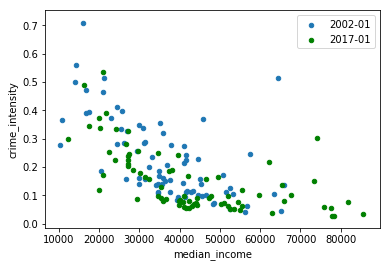

In [77]:
ax = crimes_vs_income[history_point].plot.scatter('median_income', 'crime_intensity', label = history_point)
crimes_vs_income[spot_point].plot.scatter('median_income', 'crime_intensity', label = spot_point, color = 'g', ax = ax)

plt.show()

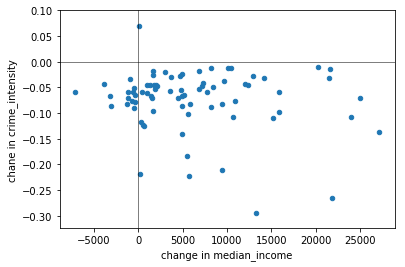

In [78]:
crimes_vs_income['difference'].plot.scatter('median_income', 'crime_intensity')
plt.xlabel('change in median_income')
plt.ylabel('chane in crime_intensity')
plt.axhline(0, color = 'k', linewidth = 0.5)
plt.axvline(0, color = 'k', linewidth = 0.5)
plt.show()

## Feature Engineering and Crime Storytelling

Here we engineer some features about crime largely for classifying which "one of those" neighborhoods (or groups of neighborhoods) are. These are features that appeared interesting and notable after taking time to understand the data. 

The idea here is to essentially filter on demographic information and get back key crime information. 

The features are...

Keys / demographics
* Race profile: Black/White/Hispanic/Mixed
* Income profile: High/Med/Low

Values / crime characteristics
* Endpoint crime High/Med/Low
* Long term crime trend: Flat/Down
* Long term crime trend relative to mean: Higher/Flat/Lower
* Contribution to change in equality
* Elevated crime categories
* Recent uptick in crime: is moving average high compared to endpoint?

... and story embellishments ...

* Income change: Up/Flat/Down
* Population: Growing/Flat/Shrinking

#### Key: Race profile (Black/White/Hispanic/Mixed)

Define the neighborhoods race as the predominant race if it's more than 50% of the population.

In [79]:
def get_primary_race(row, race_thresh_classify = 0.5):
    max_race = row.idxmax()
    # there is one neighborhood (chinatown) that's asian. since it's VERY tiny we don't want it to overly complicate
    # the narrative
    return 'mixed' if row[max_race] < race_thresh_classify or max_race in ('other', 'asian') else max_race

# already sorted by time so just drop the column and take last
neighb_primary_race = neighb_pct_population.drop('time', axis = 1)\
    .groupby('neighborhood').last()
    
neighb_primary_race['primary_race'] = neighb_primary_race.apply(get_primary_race, axis = 1)
neighb_primary_race = neighb_primary_race[['primary_race']]

#### Key: Income profile (High/Med/Low)

* \> 60% above city median $\rightarrow$ high income
* \> 60% below city median $\rightarrow$ low income
* else $\rightarrow$ medium income

In [80]:
city_median_income = chicago_incomes['median_income'].values[-1]

In [81]:
# calculate by associating a "factor" with the "above median" category
# one bucket contains the median -- this one needs to be divided assumiung even distribution within the bucket

def get_factor_above_median_from_col_name(col, city_median):
    # just assign numbers for sake of median calc -- these will not affect median
    if 'Less' in col and '$10,000' in col:
        return 0.0
    elif '$200,000' in col:
        return 1.0 
    # edge cases handled by here
    numbers = sorted([ int(num) for num in col.replace(',', '').replace('$', '').split(' to ') ])
    if max(numbers) < city_median:
        return 0.0
    elif min(numbers) > city_median:
        return 1.0
    else: # bucket contains median
        return (city_median - min(numbers))/(max(numbers) - min(numbers))
    

factor_above_median_income_col = { col : get_factor_above_median_from_col_name(col, city_median_income)\
                                   for col in neighb_incomes if col not in [ 'neighborhood', 'median_income', 'time' ]}

In [82]:
def get_income_classification(row, factor_above_median_income_col, fraction_thresh = 0.6):
    total_pop = row.sum()
    pct_above_median = sum([ factor_above_median_income_col[idx] * val / total_pop for idx, val in row.iteritems()])
    if pct_above_median > fraction_thresh:
        return 'high'
    elif pct_above_median < 1 - fraction_thresh:
        return 'low'
    else:
        return 'medium'

In [83]:
neighb_income_profile = neighb_incomes.drop(['time', 'median_income'], axis = 1)\
    .groupby('neighborhood').last()
    
neighb_income_profile['income_class'] = \
    neighb_income_profile.apply(lambda row: get_income_classification(row, factor_above_median_income_col), axis = 1)
    
neighb_income_profile = neighb_income_profile[['income_class']]

In [84]:
neighb_income_profile.reset_index().groupby('income_class').agg('count')

,neighborhood
income_class,
high,14
low,29
medium,34


#### Value: Crime level (High/Med/Low)

Similar to incomes, define high/med/low relative to city median crime. Also look at an endpoint here.

In [85]:
def get_crime_level_description(crime_relative_to_city):
    if crime_relative_to_city < 0.5:
        return 'low'
    elif crime_relative_to_city > 1.5:
        return 'high'
    else:
        return 'normal'

In [86]:
city_crime_level = chicago_crimes_percapita.sum(axis = 1).values[-1]

neighb_crime_level = pd.DataFrame({'total_crime' : neighb_crimes_percapita.sum(axis = 1)})\
    .reset_index().drop('time', axis = 1).groupby('neighborhood').last()
    
neighb_crime_level['crime_level'] = (neighb_crime_level['total_crime'] / city_crime_level).map(get_crime_level_description)

neighb_crime_level = neighb_crime_level.drop('total_crime', axis = 1)

In [87]:
neighb_crime_level.reset_index().groupby('crime_level').count()

,neighborhood
crime_level,
high,21
low,17
normal,39


#### Value: Long term crime trend (Flat/Decrease)

There are virtually no neighborhoods whose long term crime increased. So, instead lets see how over all history crime has changed. If it's stayed relatively flat (i.e. < 20% decrease), call it flat.

In [88]:
neighb_long_term_crime_trend = pd.DataFrame({'total_crime' : neighb_crimes_percapita.sum(axis = 1)})\
    .reset_index().groupby('neighborhood')\
    .agg(['first', 'last'])['total_crime']
    
neighb_long_term_crime_trend['long_term_crime'] = np.where(
    (1 - neighb_long_term_crime_trend['last']/neighb_long_term_crime_trend['first']) < 0.2,
    'flat',
    'decrease'
)

neighb_long_term_crime_trend = neighb_long_term_crime_trend[['long_term_crime']]

In [89]:
neighb_long_term_crime_trend.reset_index().groupby('long_term_crime').count()

,neighborhood
long_term_crime,
decrease,69
flat,8


#### Value: Change Relative to Chicago Mean

Look at how the neighborhood has changed relative to the Chicago mean -- this informs inequality

In [90]:
def get_crime_chg_rel_mean_classification(change, change_thresh = 0.075):
    if change < -change_thresh:
        return 'decrease'
    elif change > change_thresh:
        return 'increase'
    else:
        return 'flat'

In [91]:
ref_date = '2002-01'
end_date = '2017-01'

neighb_chg_rel_mean = pd.DataFrame({'total_crime' : neighb_crimes_percapita.sum(axis = 1)}).join(
    pd.DataFrame({'city_crime' : chicago_crimes_percapita.sum(axis = 1)})
).loc[pd.IndexSlice[:, [ref_date, end_date]], :]

neighb_chg_rel_mean['crime_rel_mean'] = neighb_chg_rel_mean['total_crime']/neighb_chg_rel_mean['city_crime'] - 1

neighb_chg_rel_mean = neighb_chg_rel_mean.reset_index()\
    .pivot_table(index = 'neighborhood', columns = 'time', values = 'crime_rel_mean')
    
neighb_chg_rel_mean.columns = neighb_chg_rel_mean.columns.map(str)

neighb_chg_rel_mean['long_term_chg_to_mean_value'] = \
    neighb_chg_rel_mean[end_date] - neighb_chg_rel_mean[ref_date]

neighb_chg_rel_mean['long_term_chg_to_mean'] = \
    neighb_chg_rel_mean['long_term_chg_to_mean_value'].map(get_crime_chg_rel_mean_classification)

#neighb_chg_rel_mean = neighb_chg_rel_mean[['long_term_chg_to_median', 'long_term_chg_to_median_value']]
neighb_chg_rel_mean = neighb_chg_rel_mean[['long_term_chg_to_mean']]

In [92]:
neighb_chg_rel_mean.reset_index().groupby('long_term_chg_to_mean').count()

time,neighborhood
long_term_chg_to_mean,
decrease,23
flat,33
increase,21


#### Value: Elevated Crime Category (Property/Violent/None)

If a significant category has an elevated level relative to the city, take note. The category is noted if its fraction of total crime is >10% the city mean.

In [93]:
city_crime_elevation_ref = chicago_crimes_percapita.sum(axis = 1, level = 0).tail(1)
city_crime_elevation_ref /= city_crime_elevation_ref.sum(axis = 1)[0]
city_crime_elevation_ref = city_crime_elevation_ref.iloc[0].transpose().to_dict()

In [94]:
def find_elevated_category(row, city_dict, elev_thresh = 0.05):
    row_dict = row.to_dict()
    biggest_diff = sorted([ [row_dict[key] - city_dict[key], key] for key in row_dict if key != 'Society'])[-1]
    if biggest_diff[0] > elev_thresh:
        return biggest_diff[1]
    else:
        return 'None' 

In [95]:
neighb_crime_elevation = neighb_crimes_percapita.sum(axis = 1, level = 0)\
    .reset_index().drop('time', axis = 1).groupby('neighborhood').last()
    
neighb_crime_elevation = neighb_crime_elevation.div(neighb_crime_elevation.sum(axis = 1), axis = 0)

neighb_crime_elevation['elevated_category'] = \
    neighb_crime_elevation.apply(lambda row: find_elevated_category(row, city_crime_elevation_ref), axis = 1)
    
neighb_crime_elevation = neighb_crime_elevation[['elevated_category']]

#### Value: Median Income Change (LargeIncrease/Increase/Flat/Decrease)

Whether median incomes have decreased at all (decrease), increased by <5k (flat), increased by 5-15k (increase) or increased by more than 15k (large increase)

Note that this does account for inflation in the raw data.

In [96]:
def get_income_change_class(income_diff, diff_thresh = 5000, large_diff_thresh = 15000):
    if income_diff < 0:
        return 'decrease'
    elif income_diff < diff_thresh:
        return 'flat'
    elif income_diff < large_diff_thresh:
        return 'increase'
    else:
        return 'large increase'

In [97]:
ref_date = '2002-01'
end_date = '2017-01'

neighb_median_income_change = (\
    neighb_incomes[neighb_incomes['time'].map(str) == end_date].set_index('neighborhood') -\
    neighb_incomes[neighb_incomes['time'].map(str) == ref_date].set_index('neighborhood')
)[['median_income']].rename(columns = {'median_income' : 'median_income_net_chg'})

neighb_median_income_change['income_change'] = neighb_median_income_change['median_income_net_chg']\
    .map(get_income_change_class)
    
neighb_median_income_change = neighb_median_income_change[['income_change']]

In [98]:
neighb_median_income_change.reset_index().groupby('income_change').count()

,neighborhood
income_change,
decrease,14
flat,28
increase,25
large increase,10


#### Value: Population Change (Growing/Flat/Declining)

Buckets: \> 5% drop means declining, 5% drop to 5% increase is flat, otherwise increasing

In [99]:
def get_pop_change_class(pop_pct_change, pop_thresh = 0.075):
    if pop_pct_change < -pop_thresh:
        return 'declining'
    elif pop_pct_change < pop_thresh:
        return 'flat'
    else:
        return 'growing'

In [100]:
ref_date = '2002-01'
end_date = '2017-01'

neighb_population_change = (\
    neighb_population[neighb_incomes['time'].map(str) == end_date].set_index('neighborhood')[['population']]/ \
    neighb_population[neighb_incomes['time'].map(str) == ref_date].set_index('neighborhood')[['population']] \
    -1
).rename(columns = {'population' : 'pct_population_change'})

neighb_population_change['population_change'] = neighb_population_change['pct_population_change']\
    .map(get_pop_change_class)
    
neighb_population_change = neighb_population_change[['population_change']]

In [101]:
neighb_population_change.reset_index().groupby('population_change').count()

,neighborhood
population_change,
declining,36
flat,34
growing,7


#### Value: Recent vs Long term -- is there an uptick?

Compare the 3 year moving average to the endpoint. If endpoint > 3yr avg + thresh, then call it an uptick. Crime is generally decreasing so recent upticks are really the only features worth mentioning.

In [102]:
def get_uptick_class(endpoint, recent_avg, uptick_thresh = 0.01):
    return 'none' if endpoint - recent_avg < uptick_thresh else 'uptick'

In [103]:
years_for_ma = 2

neighb_uptick = pd.DataFrame({'total_crime' : neighb_crimes_percapita.sum(axis = 1)})\
    .reset_index().groupby('neighborhood')\
    .tail(years_for_ma * 12)\
    .groupby('neighborhood')\
    .agg(['last', 'mean'])['total_crime']\
    .rename(columns = {'last' : 'endpoint', 'mean' : 'recent_moving_avg'})
    
neighb_uptick['uptick'] = neighb_uptick\
    .apply(lambda row: get_uptick_class(row['endpoint'], row['recent_moving_avg']), axis = 1)

neighb_uptick = neighb_uptick[['uptick']]

In [104]:
neighb_uptick.reset_index().groupby('uptick').count()

,neighborhood
uptick,
none,64
uptick,13


#### Neighborhood population as pct of city for weighting

In [105]:
neighb_pop_feature_weight = neighb_population.groupby('neighborhood').last()[['population']]
neighb_pop_feature_weight['pop_pct'] = neighb_pop_feature_weight['population']/\
    city_population['population'].values[-1]

### Putting it all together

Here we concatenate all the features and then do a classification of one of the 3 archetypes of chicago communities

1. The Affluents: rising income, crime decrease relative to average
2. The Proletarians: incomes flat or increasing, changes in crime follows city average
3. The Distressed: flat or dropping income, crime increase relative to average

In [106]:
neighborhood_map_features = pd.concat([
    neighb_primary_race,
    neighb_income_profile,
    neighb_crime_level,
    neighb_long_term_crime_trend,
    neighb_chg_rel_mean,
    neighb_crime_elevation,
    neighb_median_income_change,
    neighb_population_change,
    neighb_uptick,
    neighb_pop_feature_weight
], axis = 1)

In [107]:
def get_archetype(row):
    if (row['income_change'] == 'decrease' and row['long_term_chg_to_mean'] == 'increase') or\
       (row['crime_level'] == 'high' and row['income_class'] != 'high'):
        return 'distressed'
    elif row['income_class'] == 'high':
        return 'affluents'
    else:
        return 'working'

# If just by changes 
#     arch_key = (row['income_change'], row['long_term_chg_to_mean'])
#     if arch_key in (('decrease', 'flat'), ('decrease', 'increase'), ('flat', 'increase')):
#         return 'distressed'
#     elif arch_key in (('increase', 'decrease'), ('large increase', 'decrease'), ('large increase', 'flat')):
#         return 'affluents'
#     else:
#         return 'working'

# If just by income
#     if row['income_class'] == 'high':
#         return 'affluents'
#     elif row['income_class'] == 'low':
#         return 'distressed'
#     else:
#         return 'working'

neighborhood_map_features['archetype'] = neighborhood_map_features.apply(get_archetype, axis = 1)

In [108]:
neighborhood_map_features.columns

Index(['primary_race', 'income_class', 'crime_level', 'long_term_crime',
       'long_term_chg_to_mean', 'elevated_category', 'income_change',
       'population_change', 'uptick', 'population', 'pop_pct', 'archetype'],
      dtype='object')

In [109]:
(neighborhood_map_features\
    .pivot_table(index = 'income_class', columns = 'long_term_chg_to_mean', aggfunc = 'sum')\
    ['pop_pct']).round(2)

long_term_chg_to_mean,decrease,flat,increase
income_class,,,
high,0.15,0.07,0.02
low,0.02,0.15,0.18
medium,0.16,0.24,0.02


In [110]:
(neighborhood_map_features\
    .pivot_table(index = 'income_class', columns = 'long_term_chg_to_mean', aggfunc = 'sum')\
    ['pop_pct'].loc[['high','medium', 'low']]).round(2)

long_term_chg_to_mean,decrease,flat,increase
income_class,,,
high,0.15,0.07,0.02
medium,0.16,0.24,0.02
low,0.02,0.15,0.18


In [111]:
neighborhood_map_features.head()

,primary_race,income_class,crime_level,long_term_crime,long_term_chg_to_mean,elevated_category,income_change,population_change,uptick,population,pop_pct,archetype
ALBANY PARK,mixed,medium,low,decrease,flat,Property,flat,declining,none,50691.0,0.018772,working
ARCHER HEIGHTS,latino,medium,normal,decrease,flat,Property,flat,flat,none,12688.0,0.004699,working
ARMOUR SQUARE,mixed,low,normal,decrease,flat,Property,decrease,growing,none,13548.0,0.005017,working
ASHBURN,mixed,high,normal,flat,increase,Property,increase,flat,none,41024.0,0.015192,affluents
AUBURN GRESHAM,black,low,high,flat,increase,Violent,decrease,declining,none,46974.0,0.017395,distressed


## Associating key measurements with geoJSON

Here we associate things like total crime, etc. with each neighborhood's geographic. This is so that we can easily visualize via geoJSON stories throughout the city.

In [112]:
chicago_geo = gpd.read_file('./data/chicago_commarea_geo_data.json')\
    .drop(['area', 'shape_area', 'perimeter', 'area_num_1', 'area_numbe', 'comarea_id', 'comarea', 'shape_len'],
          axis = 1)

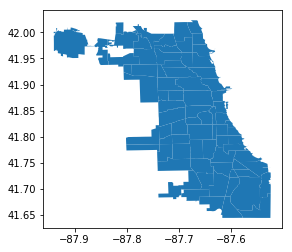

In [113]:
chicago_geo.plot()
plt.show()

In [114]:
chicago_geo.head()

,community,geometry
0,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...


In [115]:
x = chicago_geo['geometry'][0]

In [116]:
early_yr = 2002
early_yr_percapita = neighb_crimes_percapita.loc[pd.IndexSlice[:, str(early_yr)+'-01'], :]
early_yr_for_join = early_yr_percapita.sum(axis = 1)\
    .reset_index()\
    .drop('time', axis = 1)\
    .rename(columns = {'neighborhood' : 'community', 0 : 'crime_intensity_' + str(early_yr)})

In [117]:
latest_yr = neighb_crimes_percapita.index.levels[1].year.max()
latest_yr_percapita = neighb_crimes_percapita.loc[pd.IndexSlice[:, str(latest_yr)+'-01'], :]
latest_yr_for_join = latest_yr_percapita.sum(axis = 1)\
    .reset_index()\
    .drop('time', axis = 1)\
    .rename(columns = {'neighborhood' : 'community', 0 : 'crime_intensity_' + str(latest_yr)})

### Attach features we want at the community level

In [118]:
chicago_geo_annot = pd.merge(chicago_geo, early_yr_for_join, on = 'community')
chicago_geo_annot = pd.merge(chicago_geo_annot, latest_yr_for_join, on = 'community')
chicago_geo_annot = pd.merge(
    chicago_geo_annot, 
    neighborhood_map_features.reset_index().rename(columns = {'index': 'community'}),
    on = 'community'
)

### Create a version with centroids instead of boundaries

In [119]:
chicago_centroid_annot = chicago_geo_annot.copy()
chicago_centroid_annot['geometry'] = chicago_centroid_annot['geometry'].map(lambda geo: geo.centroid)

### Take a look

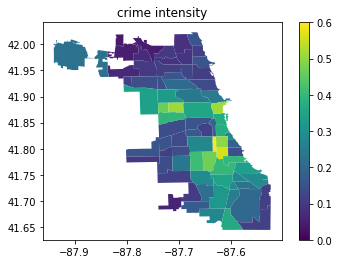

In [120]:
chicago_geo_annot.plot(column = 'crime_intensity_2002', legend = True, vmin = 0, vmax = 0.6)
plt.title('crime intensity')
plt.show()

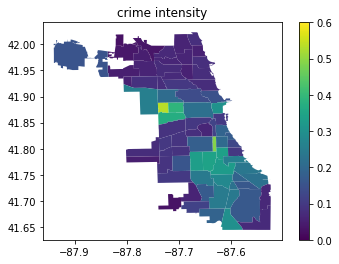

In [121]:
chicago_geo_annot.plot(column = 'crime_intensity_2017', legend = True, vmin = 0, vmax = 0.6)
plt.title('crime intensity')
plt.show()

## Outputs

TODO: 
* Update description
* Abstract outputs w/ yr filtering and output path

Finally we will save key outputs the analyses above for d3 visualization upstream

For the city-wide data, we store monthly timeseries aggregates

For the neighborhood information, we store a geojson whose attributes contain things like timeseries

We additionally produce "other" outputs:
* Crime severity 
* Gini curve

In [122]:
start_year = 2002

In [123]:
# crime type output
chicago_crimes_percapita_crimetype_out = chicago_crimes_percapita.sum(axis = 1, level = 0).reset_index()
chicago_crimes_percapita_crimetype_out = chicago_crimes_percapita_crimetype_out[
    chicago_crimes_percapita_crimetype_out['time'].dt.year >= start_year
]
chicago_crimes_percapita_crimetype_out.to_csv('./microblog/app/static/data/chicago_crimes_percapita_crimetype.csv', 
                                              index=False)

In [124]:
# crime detail / description level output
chicago_crimes_percapita_crimelevel_out = \
    pd.melt(chicago_crimes_percapita.reset_index(), id_vars=['time'], value_name='crime_intensity')
chicago_crimes_percapita_crimelevel_out = chicago_crimes_percapita_crimelevel_out[
    chicago_crimes_percapita_crimelevel_out['time'].dt.year >= start_year
]
chicago_crimes_percapita_crimelevel_out.to_csv('./microblog/app/static/data/chicago_crimes_percapita_crimelevel.csv',
                                               index = False)

In [125]:
# number of crimes in worst x% output
crime_top_bot_out = crime_top_bot.copy()
crime_top_bot_out = crime_top_bot_out[
    crime_top_bot_out.index.map(lambda x: x.year) >= start_year
]
for crime_type in crime_top_bot_out.columns.levels[0]:
    crime_top_bot_out[crime_type].reset_index()\
        .to_csv('./microblog/app/static/data/' + crime_type +\
                '_crimes_top_bot_' + str(round(100*top_pct_consider)) + '.csv',
                index = False)

# and the endpoints
crime_top_bot_summary_out = \
    pd.melt(crime_top_bot_out.iloc[[0, -1]].transpose().reset_index().rename(columns = {'level_1': 'variable'}),
            id_vars = ['crime_type', 'variable'])
crime_top_bot_summary_out['time'] = crime_top_bot_summary_out['time'].map(lambda x: x.year)
crime_top_bot_summary_out = crime_top_bot_summary_out.rename(columns = {'time' : 'year'})
crime_top_bot_summary_out['time_type'] =\
    crime_top_bot_summary_out['year'].map(lambda x: 'start' if x < 2010 else 'endpoint')
crime_top_bot_summary_out\
    .to_csv('./microblog/app/static/data/crimes_top_bot_' + str(round(100*top_pct_consider)) + '_endpoints.csv',
            index = False)

In [126]:
# geo-tagged measurements
geo_out_name = './microblog/app/static/data/chicago_geo.json'
centroid_out_name = './microblog/app/static/data/chicago_centroid.json'
if os.path.isfile(geo_out_name):
    os.remove(geo_out_name) # remove b/c rewrite bug in geopandas
chicago_geo_annot.to_file(geo_out_name, driver = 'GeoJSON')
if os.path.isfile(centroid_out_name):
    os.remove(centroid_out_name) # remove b/c rewrite bug in geopandas
chicago_centroid_annot.to_file(centroid_out_name, driver = 'GeoJSON')

In [127]:
# neighborhood crime aggregates over time -- include city of chicago_

neighb_crimes_percapita_out = neighb_crimes_percapita.sum(axis = 1).reset_index()\
    .rename(columns = {0 : 'neighb_crime_intensity'})
neighb_crimes_percapita_out = neighb_crimes_percapita_out[
    neighb_crimes_percapita_out['time'].dt.year >= start_year
]
neighb_crimes_percapita_out = neighb_crimes_percapita_out\
    .pivot_table(index = 'time', columns = 'neighborhood', values = 'neighb_crime_intensity')
    
# chicago total intensity for join
neighb_crimes_city_reference_out = pd.DataFrame({'city_crime_intensity' : chicago_crimes_percapita.sum(axis = 1)})

# create directory if doesn't exist
neighb_intensity_directory = os.path.dirname('./microblog/app/static/data/neighb_intensity/')
if not os.path.exists(neighb_intensity_directory):
    os.makedirs(neighb_intensity_directory)
    
for neighb in neighb_crimes_percapita_out:
    temp_neighb_intensity_out = neighb_crimes_percapita_out[[neighb]]\
        .join(neighb_crimes_city_reference_out)\
        .rename(columns = {neighb : 'neighb_crime_intensity'})\
        .reset_index()
    temp_neighb_intensity_out.to_csv(neighb_intensity_directory + '/' + neighb + '_intensity.csv', index = False)